In [ ]:
# Modules for structuring text
from typing import Annotated
from typing_extensions import TypedDict

# LangGraph modules for defining graphs
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Module for setting up OpenAI
# from langchain_openai import ChatOpenAI



ModuleNotFoundError: No module named 'langchain_openai'

In [3]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

## Building graph and agent states


In [9]:
# Define the State
class State(TypedDict):
    # Define messages with metadata    
    messages: Annotated[list, add_messages]
# Initialize StateGraph
graph_builder = StateGraph(State)


Adding nodes and edges

In [10]:
# Define chatbot function to respond# with the model
def chatbot(state: State):
    response = llm.invoke(state["messages"])
    return {"messages":  [response]}
# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

## Connect the graph nodes: START -> chatbot -> END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()


In [6]:
graph.invoke({"messages": ["Hello, how are you?"]})

Chatbot response: content="I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings in the same way humans do, but I am functioning optimally and ready to assist you. How can I help you today?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--f021f824-b68b-426c-9e84-c33af1d0daf0-0' usage_metadata={'input_tokens': 6, 'output_tokens': 50, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}}


{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='02301273-a277-4ecf-84c5-a9eb28b52c34'),
  AIMessage(content="I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings in the same way humans do, but I am functioning optimally and ready to assist you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f021f824-b68b-426c-9e84-c33af1d0daf0-0', usage_metadata={'input_tokens': 6, 'output_tokens': 50, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}})]}

## Streaming LLM responses


In [11]:
def stream_graph_updates(user_input: str):
    # Start streaming events from the graph with the user's input
    for event in graph.stream({"messages": [("user", user_input)]}):
        # Retrieve and print the chatbot node responses
        for value in event.values():
            print("Agent:", value["messages"], end="|")

# Define the user query and run the chatbot
user_query = "Who is Dinh Trung Thao?"
stream_graph_updates(user_query)

Agent: [AIMessage(content="Dinh Trung Thao is a Vietnamese politician and a prominent figure in the National Assembly. He currently serves as the **Vice Chairman of the National Assembly of Vietnam**.\n\nHere's a brief overview of his role and importance:\n\n*   **Vice Chairman:** As Vice Chairman, he is one of the top leaders in the National Assembly, assisting the Chairman in managing the Assembly's activities and representing it when the Chairman is unavailable.\n*   **National Assembly:** The National Assembly is the highest representative body of the people and the highest organ of state power in Vietnam. It is responsible for making laws, deciding on major policies, and overseeing the activities of the state.\n*   **Influence:** Dinh Trung Thao, in his position, plays a significant role in shaping legislation and policy within Vietnam.\n\nTherefore, Dinh Trung Thao is a key figure in the Vietnamese government, holding a high-ranking position in the country's legislative body.", a

## Generate a LangGraph diagram


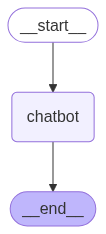

In [12]:
from IPython.display import Image, display
# Try generating and displaying # the graph diagram
try:    
    display(Image(graph.get_graph().draw_mermaid_png()))
    # Return an exception if necessary  
except Exception:
    print("Additional dependencies required.")


# Adding external tools to a chatbot

Adding a Wikipedia tool

In [16]:
%pip install wikipedia
%pip install langchain-community

from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

# Initialize Wikipedia API wrapper to fetch top 1 result
api_wrapper = WikipediaAPIWrapper(top_k_results=1)
# Create a Wikipedia query tool using the API wrapper

wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper)
tools = [wikipedia_tool]

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
Using cached beautifulsoup4-4.13.4-py3-none-any.whl (187 kB)
Using cached soupsieve-2.7-py3-none-any.whl (36 kB)
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11785 sha256=81e825774ec8597a84cdb4fa0d6515f03b773f8a1599cb9009a0e71396a4973c
  Stored in directory: c:\users\trung thao\appdata\local\pip\cache\wheels\8f\ab\cb\45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia

   ---------------------------------------- 0/3 [soupsieve]
   ------------- ------------------------

In [17]:
# Bind the Wikipedia tool to 
# the language model
llm_with_tools = llm.bind_tools(tools)

# Modify chatbot function to # respond with Wikipedia
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

## Adding tool nodes



In [19]:
#Modules for adding tool conditions # and nodes
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

In [20]:
# Create a ToolNode to handle tool calls # and add it to the graph
tool_node = ToolNode(tools=[wikipedia_tool])
graph_builder.add_node("tools", tool_node)

In [21]:
# Set up a condition to direct from chatbot to tool or end node
graph_builder.add_conditional_edges("chatbot", tools_condition)

In [22]:
# Connect tools back to chatbot and  # add START and END nodes
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


In [23]:
graph = graph_builder.compile()

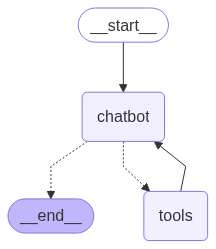

In [24]:
from IPython.display import Image, display
# Try generating and displaying # the graph diagram
try:    
    display(Image(graph.get_graph().draw_mermaid_png()))
    # Return an exception if necessary  
except Exception:
    print("Additional dependencies required.")


In [25]:
def stream_tool_responses(user_input: str):
    # Start streaming events from the graph with the user's input
    for event in graph.stream({"messages": [("user", user_input)]}):
        # Retrieve and print the chatbot node responses
        for value in event.values():
            print("Agent:", value["messages"], end="|")

In [26]:
user_query = "House of Lords"
stream_tool_responses(user_query)


Agent: [AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "House of Lords"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--4a84c214-3306-4bff-96f4-4e3c7d572e14-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'House of Lords'}, 'id': 'ce35fda5-6801-4080-b882-54cb080587f7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 5, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}})]|Agent: [ToolMessage(content='Page: House of Lords\nSummary: The House of Lords is the upper house of the Parliament of the United Kingdom. Like the lower house, the House of Commons, it meets in the Palace of Westminster in London, England. One of the oldest extant institutions in the world, its origins lie in the early 11th century and the emergence of bicameralism in the 13th century.\nIn

## Adding memory

In [ ]:
# # Import the modules for saving memory
# from langgraph.checkpoint.memory import MemorySaver
# # Modify the graph with memory checkpointing
# memory = MemorySaver()  # Compile the graph passing in memory
# graph = graph_builder.compile(checkpointer=memory)
